## Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tarfile
import os
import random
import gc

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,UpSampling2D
from tensorflow.keras.models import Sequential, Model

print('All the libraries are loaded')

All the libraries are loaded


In [85]:
code_size=32
pad ='same'
img_shape=[256,256,3]
encoder = Sequential()
encoder.add(Conv2D(filters=32,kernel_size=3,input_shape=(256,256,3)))
encoder.add(MaxPool2D(pool_size=(2,2)))
encoder.add(Conv2D(filters=16,kernel_size=3))
encoder.add(MaxPool2D(pool_size=(2,2)))
encoder.add(Conv2D(filters=8,kernel_size=3))
encoder.add(MaxPool2D(pool_size=(2,2)))
encoder.add(Flatten())
encoder.add(Dense(code_size))

#The Decoder
shape_pooling = encoder.layers[-3].output_shape
shape_flatten = encoder.layers[-2].output_shape
decoder = Sequential()
decoder.add(Dense(shape_flatten[1],input_shape=(code_size,)))
decoder.add(Reshape((shape_pooling[1],shape_pooling[2],shape_pooling[3])))
# decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=8,kernel_size=5,padding=pad))
decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=16,kernel_size=3,padding=pad))
decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=32,kernel_size=3,padding=pad))
decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=3,kernel_size=3,padding=pad))
decoder.add(Flatten())
decoder.add(Dense(np.prod(img_shape)))
decoder.add(Reshape((256,256,3)))

ResourceExhaustedError: OOM when allocating tensor with shape[172800,196608] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
decoder.summary()

In [83]:
img_shape=[256,256,3]
np.prod(img_shape)

196608

In [59]:
encoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 60, 60, 8)         1160      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 7200)            

## Preliminary 

In [2]:
# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME = "lfw_attributes.txt"

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = "lfw-deepfunneled.tgz"

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = "lfw.tgz"

In [98]:
### Data Loader
'''
The code of the data loaded is being taken from the website
https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
'''
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

### Model
def build_autoencoder(img_shape, code_size,name):
    if name == 'Simple':
        # The encoder
        encoder = Sequential()
        encoder.add(InputLayer(img_shape))
        encoder.add(Flatten())
        encoder.add(Dense(code_size))

        # The decoder
        decoder = Sequential()
        decoder.add(InputLayer((code_size,)))
        decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
        decoder.add(Reshape(img_shape))

        return encoder, decoder
    
    elif name == 'CNN':
        pad='same'
        #The encoder
        encoder = Sequential()
        encoder.add(Conv2D(filters=128,kernel_size=3,input_shape=(img_shape)))
        encoder.add(MaxPool2D(pool_size=(2,2)))
        encoder.add(Conv2D(filters=64,kernel_size=3))
        encoder.add(MaxPool2D(pool_size=(2,2)))
        encoder.add(Conv2D(filters=32,kernel_size=3))
        encoder.add(MaxPool2D(pool_size=(2,2)))
        encoder.add(Flatten())
        encoder.add(Dense(code_size))

        #The Decoder
        shape_pooling = encoder.layers[-3].output_shape
        shape_flatten = encoder.layers[-2].output_shape
        decoder = Sequential()
        decoder.add(Dense(shape_flatten[1],input_shape=(code_size,)))
        decoder.add(Reshape((shape_pooling[1],shape_pooling[2],shape_pooling[3])))
        decoder.add(UpSampling2D(size=(2,2)))
        decoder.add(Conv2D(filters=32,kernel_size=3,padding=pad))
        decoder.add(UpSampling2D(size=(2,2)))
        decoder.add(Conv2D(filters=64,kernel_size=3,padding=pad))
        decoder.add(UpSampling2D(size=(2,2)))
        decoder.add(Conv2D(filters=128,kernel_size=3,padding=pad))
        decoder.add(UpSampling2D(size=(2,2)))
        decoder.add(Conv2D(filters=3,kernel_size=3,padding=pad))
        
        return encoder,decoder

### Visualizations
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(np.clip(img, 0, 1))

#     plt.subplot(1,3,2)
#     plt.title("Code")
#     plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(np.clip(reco, 0, 1))
    plt.show()
    
    print('-'*30,'SSIM:',ssim(img[0],reco[0],multichannel=True),'-'*30)
    
    return

### Metric
def overall_ssim(actual,predicted):
    assert len(actual)==len(predicted)
    results = []
    for i in range(len(actual)):
        s = ssim(actual[i],predicted[i],multichannel=True)
        results.append(s)
    results = np.array(results)
    return np.mean(results)

## Main

### Data Preparation

In [86]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
X = X.astype('float32') / 255.0

C:\Users\Saad.LAKES\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


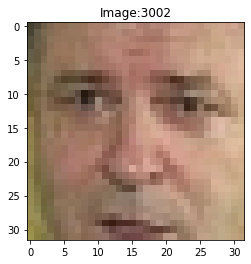

In [87]:
num = random.randint(0,len(X))

plt.imshow(np.clip(X[num], 0, 1))
plt.title(f'Image:{num}')
plt.show()

### Data Split

In [88]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')

The shape of X_train is (11828, 32, 32, 3)
The shape of X_test is (1315, 32, 32, 3)


### Model Training

In [99]:
IMG_SHAPE = X.shape[1:]
embed_size = 1000
encoder, decoder = build_autoencoder(IMG_SHAPE, embed_size,name='CNN')

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse',metrics=['mae'])

print(autoencoder.summary())

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_54 (Sequential)   (None, 1000)              224840    
_________________________________________________________________
sequential_55 (Sequential)   (None, 32, 32, 3)         233187    
Total params: 458,027
Trainable params: 458,027
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/200
296/296 [==============================] - 2s 8ms/step - loss: 0.0319 - mae: 0.1186 - val_loss: 0.0148 - val_mae: 0.0901
Epoch 2/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0137 - mae: 0.0863 - val_loss: 0.0124 - val_mae: 0.0824
Epoch 3/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0117 - mae: 0.0792 - val_loss: 0.0107 - val_mae: 0.0751
Epoch 4/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0107 - mae: 0.0756 - val_loss: 0.0100 - val_mae: 0.0727
Epoch 5/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0101 - mae: 0.0735 - val_loss: 0.0097 - val_mae: 0.0717
Epoch 6/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0095 - mae: 0.0707 - val_loss: 0.0091 - val_mae: 0.0695
Epoch 7/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0091 - mae: 0.0693 - val_loss: 0.0088 - val_mae: 0.0680
Epoch 8/200
296/296 [==============================] - 2s 7ms/step - 

296/296 [==============================] - 2s 7ms/step - loss: 0.0048 - mae: 0.0496 - val_loss: 0.0053 - val_mae: 0.0513
Epoch 124/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0048 - mae: 0.0499 - val_loss: 0.0053 - val_mae: 0.0513
Epoch 125/200
296/296 [==============================] - 2s 8ms/step - loss: 0.0047 - mae: 0.0495 - val_loss: 0.0052 - val_mae: 0.0509
Epoch 126/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0048 - mae: 0.0495 - val_loss: 0.0053 - val_mae: 0.0519
Epoch 127/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0048 - mae: 0.0496 - val_loss: 0.0052 - val_mae: 0.0510
Epoch 128/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0048 - mae: 0.0497 - val_loss: 0.0053 - val_mae: 0.0514
Epoch 129/200
296/296 [==============================] - 2s 7ms/step - loss: 0.0047 - mae: 0.0495 - val_loss: 0.0052 - val_mae: 0.0510
Epoch 130/200
296/296 [==============================] - 2s 7ms/step 

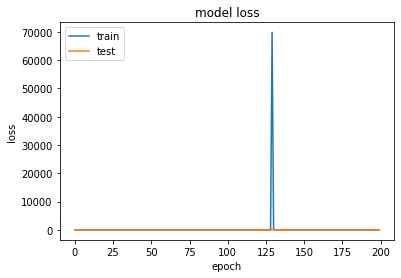

In [100]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=200,validation_split=0.2,batch_size=32)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predictions

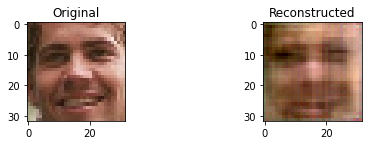

------------------------------ SSIM: 0.5981239998997084 ------------------------------


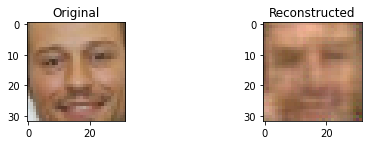

------------------------------ SSIM: 0.8410119348261306 ------------------------------


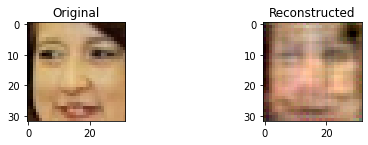

------------------------------ SSIM: 0.4756390082852528 ------------------------------


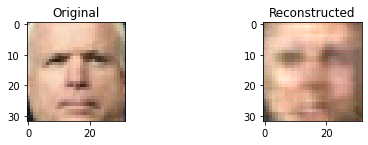

------------------------------ SSIM: 0.6100590098474307 ------------------------------


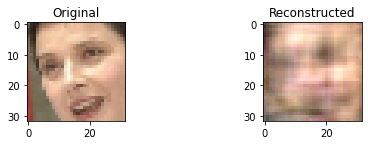

------------------------------ SSIM: 0.615922251455366 ------------------------------


In [101]:
num_test = random.sample(range(0,len(X_test)),5)
for i in num_test:
    img = X_test[i]
    visualize(img,encoder,decoder)

In [102]:
bottle = encoder.predict(X_test)
predicted = decoder.predict(bottle)

print(f'The average Similarity image is : {round(overall_ssim(X_test,predicted),2)}')
print(f'The compression rate is: {round((np.prod(IMG_SHAPE)/embed_size),2)}')

The average Similarity image is : 0.63
The compression rate is: 3.07


## Experiment

In [ ]:
show_image(X_test[0])
plt.savefig('original.jpg')

In [ ]:
random = X_test[0]
random=np.expand_dims(random,axis=0)
random.shape

In [ ]:
bottle = encoder.predict(random)
bottle.shape

In [ ]:
new_image = decoder.predict(bottle)
new_image.shape

In [ ]:
plt.imshow(new_image[0])
plt.savefig('reconstructed.jpg')

In [ ]:
s = ssim(random[0], new_image[0],multichannel=True)

In [ ]:
s

In [ ]:
random.sample(range(0, 1000), 10)